## Confidence DDM with Bayesflow

This is an example of the implementation of Bayesflow. We will set-up the Confidence DDM model. 

This code includes adaptations from the code scripts of **Prof. Michael D. Nunez** and **Dr. Amin Ghaderi**. You can find Prof. Nunez's [Github](https://github.com/mdnunez/bayesflow_nddms/blob/main/basic_ddm.py) and [relevant paper](https://doi.org/10.31234/osf.io/h4fde) and Dr. Ghaderi's [Github](https://github.com/AGhaderi/NDDM/blob/main/Single-trial-Integrative-CPP/Model7/CPP_single_trial_sigma_eta.py) and [relevent paper](https://doi.org/10.1007/s42113-023-00167-4) here.

## Import modules

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from tqdm.autonotebook import tqdm # for bayesflow
import bayesflow as bf
from numba import njit
from scipy.stats import truncnorm
from pyhddmjagsutils import recovery, recovery_scatter, plot_posterior2d
from plots import scatterplot_simulated_data, hist_simulated_data
print('Modules imported.')

Modules imported.


## Set model name

In [20]:
model_name = 'ConfidenceDDMwithoutEEG_Pe'
output_filename = 'Simulation_results'

make_recovery_plots = True
train_fitter = False

## Useful functions 

In [21]:
# Functions to generate a prior distribution for all model parameters
def prior_N(n_min=60, n_max=300):
    """A prior for the random number of observation"""
    return np.random.randint(n_min, n_max+1)

# For easier definition of truncated normals
def truncnorm_better(mean=0, sd=1, low=-10, upp=10, size=1):
    return truncnorm.rvs(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd, size=size)

## Define priors

In [22]:
def draw_prior():
    
    """ 
    Setting prior distributions.
    
    Drift(1), Boundary(2), Beta (3; start point), Tau (4; non-decision time), 
    Eta (5; variance |e| trials), Confidence drift(6), Confidence Boundary(7), Confidence Tau(8), 
    Confidence Eta (9) 
    
    """
        
    # mu_drift ~ N(0, 2.0) # mean of drift rate
    mu_drift = np.random.normal(0.0, 2.0) 

    # boundary  ~ N(1.0, 0.5) in [0, 10] #boundary
    boundary = truncnorm_better(mean=1.0, sd=0.5, low=0.0, upp=10)[0]
    
    # beta ~ Beta(2.0, 2.0)  # relative start point
    beta = np.random.beta(2.0, 2.0)
    
    # tau ~ N(0.5, 0.25) in [0, 1.5] #non-decision time
    tau = truncnorm_better(mean=0.5, sd=0.25, low=0.0, upp=1.5)[0]
        
    # Eta ~ N(0, 0.5) # standard deviation in drift rates between trials 
    eta =  truncnorm_better(mean=0, sd=0.5, low=0.0, upp=10)[0] 
  
    # conf_mu_drift ~ N(0, 2.0) # mean post-decisional drift (v2)
    conf_mu_drift =  np.random.normal(0.0, 2.0) 
        
    # conf_boundary ~  N(1.0, 0.5) in [0, 10] # confidence boundaries
    conf_boundary  = truncnorm_better(mean=1.0, sd=0.5, low=0.0, upp=10)[0]
    
    # conf_tau ~ N(0.5, 0.25) # confidence non-decision time
    conf_tau = truncnorm_better(mean=0.5, sd=0.25, low=0.0, upp=1.5)[0]
    
    # conf_eta ~ N(0, 0.5) # standard deviation in v2 
    conf_eta = truncnorm_better(mean=0, sd=0.5, low=0.0, upp=10)[0] 

    
    p_samples = np.hstack((mu_drift, boundary, beta, tau, eta, conf_mu_drift, conf_boundary, conf_tau, conf_eta))
    return p_samples

num_params = len(draw_prior()) # Get the number of parameters

## Define the model to simulate trials 

In [23]:
# Define the model in simulation 
@njit
def diffusion_trial(mu_drift, boundary, beta, tau, eta,
                    conf_mu_drift, conf_boundary, conf_tau, conf_eta,
                    dc=1.0, dt=.005):
    
    """Simulates a trial from the confidence drift-diffusion model."""

    evidence = boundary * beta


######### Decision #########
    n_steps = 0.
    
    # trial-to-trial drift rate variability
    drift_trial = np.random.normal(mu_drift, eta)
    
    # Simulate a single choice DM path
    while (evidence > 0 and evidence < boundary):

        # DDM equation
        evidence += drift_trial*dt + np.sqrt(dt) * dc * np.random.normal()

        # Increment step
        n_steps += 1.0

    choicert = n_steps * dt + tau

    if evidence >= boundary:
        choice =  1  # choice A
    elif evidence <= 0:
        choice = -1  # choice B
    else:
        choice = 0  # This indicates a missing response

######### Confidence #########
    n_conf_steps = 0.
    
    # trial-to-trial drift rate variability
    conf_drift_trial = np.random.normal(conf_mu_drift, conf_eta)
    
    #Pe
    # pe = np.random.normal(v2_intercept + v2_slope * conf_drift_trial, sigma)
    
    if choice == 1:
        while ((evidence < boundary + conf_boundary/2) and (evidence > boundary - conf_boundary/2)):
    
            # DDM equation
            evidence += conf_drift_trial*dt + np.sqrt(dt) * dc * np.random.normal()
    
            # Increment step
            n_conf_steps += 1.0
    
        conf_rt = n_conf_steps * dt + conf_tau
    
        if evidence >= boundary + conf_boundary/2:
            conf =  1  # high confidence
        elif evidence <= boundary - conf_boundary/2:
            conf = -1  # low confidence
        else:
            conf = 0  # This indicates a missing response
    
    elif choice  == -1 :
        while ((evidence < conf_boundary/2) and (evidence > - conf_boundary/2)):
    
            # DDM equation
            evidence += conf_drift_trial*dt + np.sqrt(dt) * dc * np.random.normal()
    
            # Increment step
            n_conf_steps += 1.0
    
        conf_rt = n_conf_steps * dt + conf_tau
    
        if evidence <= - conf_boundary/2:
            conf =  1  # high confidence
            
        elif evidence >=  conf_boundary/2:
            conf = -1  # low confidence
            
        else:
            conf = 0  # This indicates a missing response
       
    return choicert, choice, conf_rt, conf

## Simulate trials and save data 

In [24]:
@njit
def simulate_trials(params, n_trials):
    """Simulates a diffusion process for trials."""

    mu_drift, boundary, beta, tau, eta, conf_mu_drift, conf_boundary, conf_tau, conf_eta  = params
    choicert = np.empty(n_trials)
    conf_rt = np.empty(n_trials)
    choice = np.empty(n_trials)
    conf = np.empty(n_trials)
    
    for i in range(n_trials):
        choicert[i], choice[i], conf_rt[i], conf[i] = diffusion_trial(mu_drift, boundary, beta, tau, eta, conf_mu_drift, conf_boundary, conf_tau, conf_eta)

  #  sim_data = np.stack((choicert, choice, conf_rt, conf, pe), axis=-1)
        sim_data = np.stack((choicert, choice, conf_rt, conf), axis=-1)       
    return sim_data

## Now we connect the priors with our simulation

- **Experimental context** refers to the specifications we want to make about the context of the experiment. Do we have a control group? How many trials are there in an experiment? Are there manipulation trials? 

- **Simulator** simulates one complete experiment for a single subject, given the context and the parameters.

- **Generative_model** then connects everything together. Generative model is a class that makes a dictionary of everything we need:
    - Prior draws
    - Context for the simulaton
    - Simulated data

In [25]:
# Define the prior
prior = bf.simulation.Prior(prior_fun=draw_prior)

# Define the context of the experiment
experimental_context = bf.simulation.ContextGenerator(non_batchable_context_fun=prior_N)

# Simulates the performance of a subject in a whole experiment given context variables
simulator = bf.simulation.Simulator(simulator_fun=simulate_trials, 
    context_generator=experimental_context)

# Connects the priors and the simulator
generative_model = bf.simulation.GenerativeModel(prior, simulator) 

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 9)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 190, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Could not determine shape of simulation non-batchable context. Type appears to be non-array: <class 'int'>,                                    so make sure your input configurator takes cares of that!
INFO:root:No optional simulation batchable context provided.


## Check the simulated data

We want to make sure that our simulation is correct and we are simulating sensible data. 

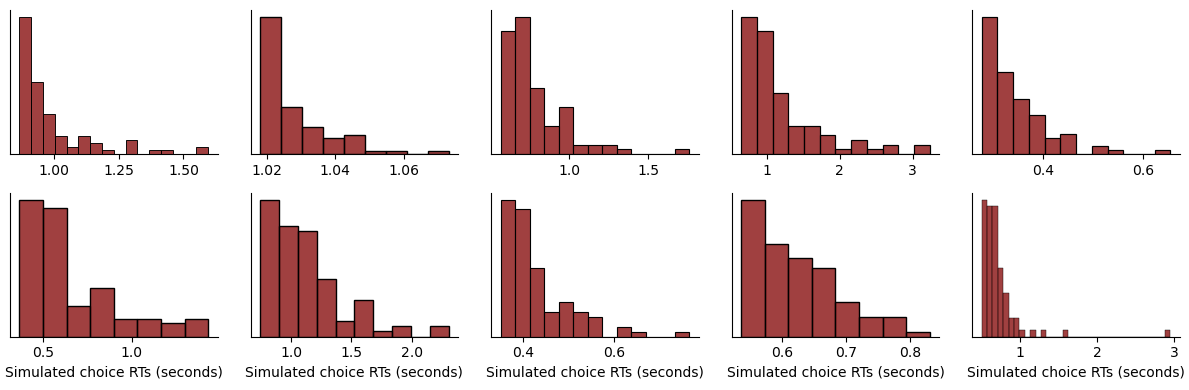

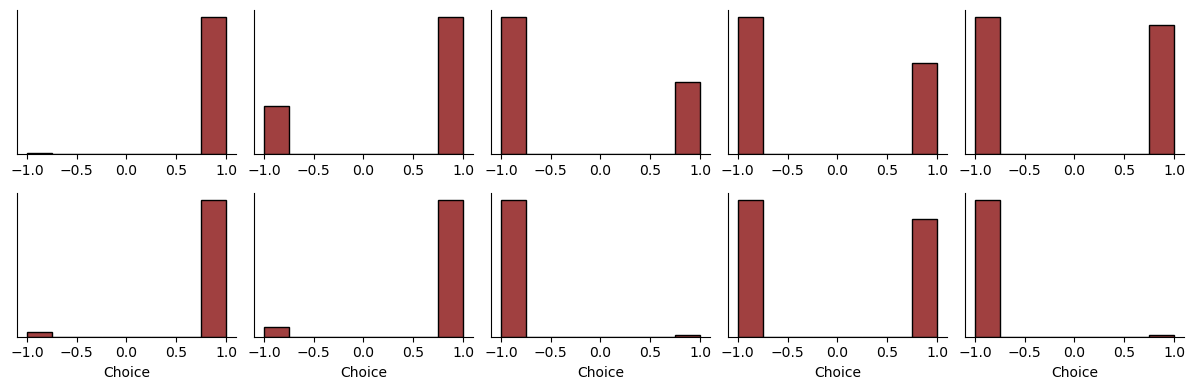

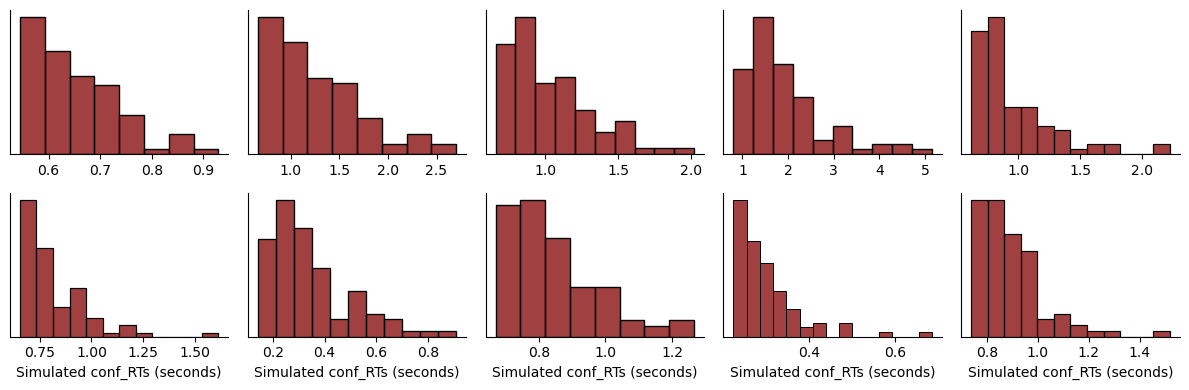

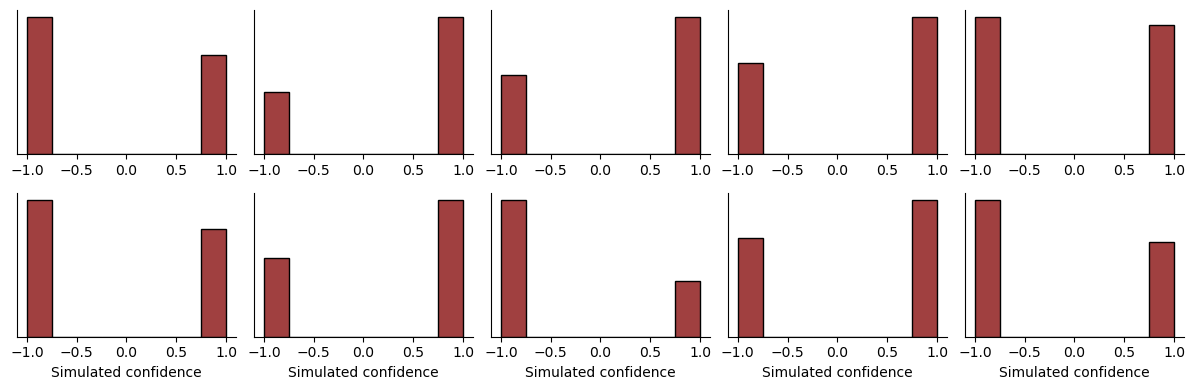

In [26]:
example_sim = generative_model(batch_size=10)

f, axarr = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in enumerate(axarr.flat):
    sns.histplot(example_sim["sim_data"][i, :, 0].flatten(), color="maroon", alpha=0.75, ax=ax)
    sns.despine(ax=ax)
    ax.set_ylabel("")
    ax.set_yticks([])
    if i > 4:
        ax.set_xlabel("Simulated choice RTs (seconds)")
f.tight_layout()

f, axarr = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in enumerate(axarr.flat):
    sns.histplot(example_sim["sim_data"][i, :, 1].flatten(), color="maroon", alpha=0.75, ax=ax)
    sns.despine(ax=ax)
    ax.set_ylabel("")
    ax.set_yticks([])
    if i > 4:
        ax.set_xlabel("Choice")
f.tight_layout()

f, axarr = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in enumerate(axarr.flat):
    sns.histplot(example_sim["sim_data"][i, :, 2].flatten(), color="maroon", alpha=0.75, ax=ax)
    sns.despine(ax=ax)
    ax.set_ylabel("")
    ax.set_yticks([])
    if i > 4:
        ax.set_xlabel("Simulated conf_RTs (seconds)")
f.tight_layout()

f, axarr = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in enumerate(axarr.flat):
    sns.histplot(example_sim["sim_data"][i, :, 3].flatten(), color="maroon", alpha=0.75, ax=ax)
    sns.despine(ax=ax)
    ax.set_ylabel("")
    ax.set_yticks([])
    if i > 4:
        ax.set_xlabel("Simulated confidence")
f.tight_layout()


## Configurator 

- Data transformations that are needed to give the appropriate input to the networks!
    - Networks work with tensors.
    - Need an extra dimension in the tensor to specify the batch (unsqueeze).
    - Log the N so they are not huge numbers. 

In [27]:
def configurator(sim_dict):
    """Configures the outputs of a generative model for interaction with 
    BayesFlow modules."""
    
    out = dict()
    # These will be passed through the summary network. In this case,
    # it's just the data, but it can be other stuff as well.
    data = sim_dict['sim_data'].astype(np.float32)
    out['summary_conditions'] = data
    
    # These will be concatenated to the outputs of the summary network
    # Convert N to log N since neural nets cant deal well with large numbers
    N = np.log(sim_dict['sim_non_batchable_context'])
    # Repeat N for each sim (since shared across batch), notice the
    # extra dimension needed
    N_vec = N * np.ones((data.shape[0], 1), dtype=np.float32)
    out['direct_conditions'] = N_vec
    
    # Finally, extract parameters. Any transformations (e.g., standardization)
    # should happen here.
    out['parameters'] = sim_dict['prior_draws'].astype(np.float32)
    return out

## Set up the networks and create checkpoint

We have two networks
1. Summary network learns the most informative summary statistics from data. 
2. Inference network goes from these summary statistics to joint posterior distribution. 

An amortizer is a wrapper here that connects the two networks to each other. 

In [28]:
# BayesFlow Setup
summary_net = bf.networks.InvariantNetwork() # learns the most informative summary stats from data 
inference_net = bf.networks.InvertibleNetwork(num_params=num_params) # from summary statistics to posterior distributions - joint posterior distribution 
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net) # connects the two networks

# Create the checkpoint path 
checkpoint_path = f"checkpoint/{model_name}"
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

# Create a plot path to save plots    
plot_path = f"recovery_plots/{model_name}"
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

/var/folders/6l/91lqstl53hnfzgx06z2vswnh0000gn/T/ipykernel_56208/2310501149.py:2: DeprecationWarning: InvariantNetwork will be deprecated. at some point. Use ``DeepSet`` instead.
  summary_net = bf.networks.InvariantNetwork() # learns the most informative summary stats from data


## Set up the Trainer 

If there is already a trained network, this should just load the pre-trained network. 

In [29]:
# Connect the networks (summary and inference) with the generative model 
trainer = bf.trainers.Trainer(
    amortizer=amortizer, # The two networks
    generative_model=generative_model, #Prior predictives
    configurator=configurator, # Transform data (if added, the prior) 
    checkpoint_path=checkpoint_path) # Save the trained net


INFO:root:Loaded loss history from checkpoint/ConfidenceDDMwithoutEEG_Pe/history_403.pkl.
INFO:root:Networks loaded from checkpoint/ConfidenceDDMwithoutEEG_Pe/ckpt-403
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


## Train the networks

In [30]:
if train_fitter:
    """Create validation simulations with some random N, if specific N is desired, need to 
    call simulator explicitly or define it with keyword arguments which can control behavior
    All trainer.train_*** can take additional keyword arguments controling the behavior of
    configurators, generative models and networks"""
    
    # Define number of validation experiments
    num_val = 300
    val_sims = generative_model(num_val)

    # Experience-replay training
    losses = trainer.train_experience_replay(epochs= 400,
                                                 batch_size=32,
                                                 iterations_per_epoch=1000,
                                                 validation_sims=val_sims)
    # Validation, Loss Curves
    print("Plotting the loss...")
    f = bf.diagnostics.plot_losses(losses['train_losses'], losses['val_losses'])
    f.savefig(f"{plot_path}/{model_name}_validation.png")
else:
    status = trainer.load_pretrained_network()
    print("Loading pre-trained network...")


Loading pre-trained network...


## Make recovery plots

For recovery plots, the mean number of simulated trials was 180 +/- 68.79


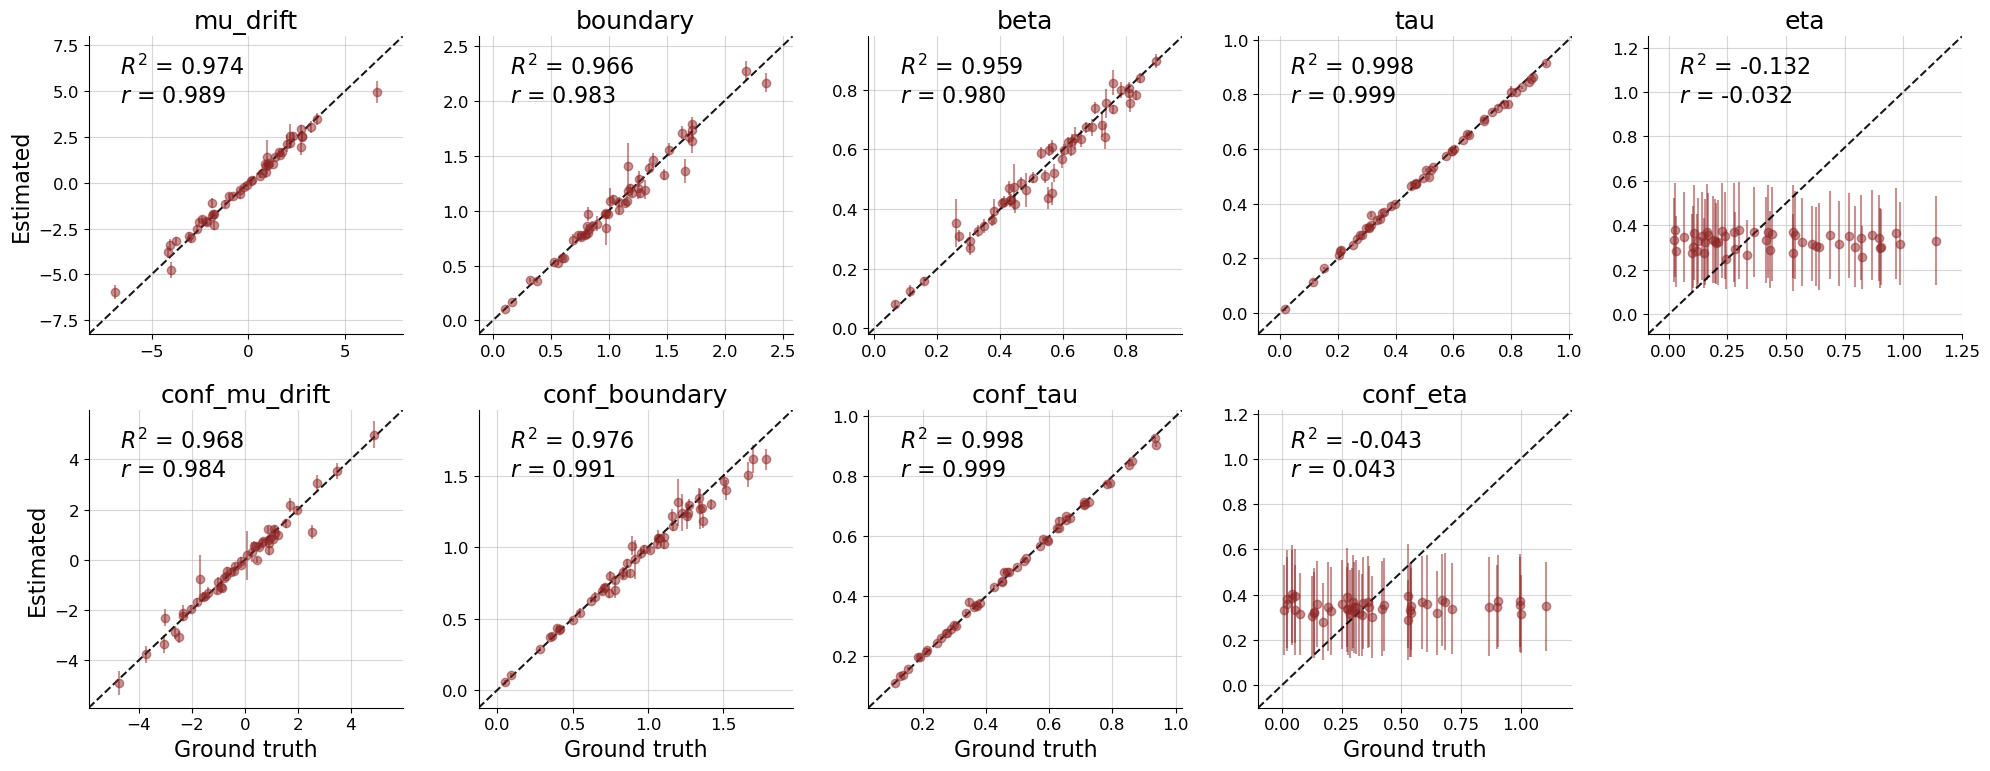

In [33]:
if make_recovery_plots:
    
 # Computational Adequacy
    num_test = 1200
    num_posterior_draws = 1000

    # Need to test for different Ns, which is what the following code does
    param_samples = np.empty((num_test, num_posterior_draws, num_params))
    true_params = np.empty((num_test, num_params))
    simulated_trial_nums = np.empty((num_test))
    data_sim = []
    
    np.random.seed(2007) # Set the random seed to generate the same plots every time
    for i in range(num_test):
        model_sims = configurator(generative_model(1))
        sims = model_sims['summary_conditions'][0]
        data_sim.extend(sims.tolist()) 
        simulated_trial_nums[i] = model_sims['summary_conditions'].shape[1]
        true_params[i, :] = model_sims['parameters']
        param_samples[i, :, :] = amortizer.sample(model_sims, n_samples=num_posterior_draws)   
            
    data_sim = np.array(data_sim)
    
    print('For recovery plots, the mean number of simulated trials was %.0f +/- %.2f' %
    (np.mean(simulated_trial_nums), np.std(simulated_trial_nums)))

    # BayesFlow native recovery plot, plot only up to 500 in each plot
    fig = bf.diagnostics.plot_recovery(param_samples[0:50,:], true_params[0:50,:], param_names =
        ['mu_drift', 'boundary', 'beta', 'tau', 'eta', 'conf_mu_drift', 'conf_boundary', 'conf_tau', 'conf_eta'])
    fig.savefig(f"{plot_path}/{model_name}_true_vs_estimate.png")